## Packages used in this EDA

The following is something you may want to run in the command prompt if you do not have the package already, this package provides some basic column analysis of tables. If you already have the package, feel free to comment it out.

<p style="background:black">
<code style="background:black;color:white">C:\Users\YOUR_USERNAME> pip install ydata_profiling
</code>
</p>

In [136]:
!pip install ydata_profiling

# EDA of Parkinson's Freezing Gait data

The following data was obtained from Kaggle. You can take a look at the competition details here:

[Parkinson's Freezing of Gait Prediction](https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction)

<div class="alert alert-block alert-info"><b>Goal:</b> "The goal of this competition is to detect freezing of gait (FOG), a debilitating symptom that afflicts many people with Parkinson’s disease. You will develop a machine learning model trained on data collected from a wearable 3D lower back sensor."</div>


For some **context**, this is pulled directly from the competition website:

> "An estimated 7 to 10 million people around the world have Parkinson’s disease, many of whom suffer from freezing of gait (FOG). During a FOG episode, a patient's feet are “glued” to the ground, preventing them from moving forward despite their attempts. FOG has a profound negative impact on health-related quality of life—people who suffer from FOG are often depressed, have an increased risk of falling, are likelier to be confined to wheelchair use, and have restricted independence.
> While researchers have multiple theories to explain when, why, and in whom FOG occurs, there is still no clear understanding of its causes. The ability to objectively and accurately quantify FOG is one of the keys to advancing its understanding and treatment. Collection and analysis of FOG events, such as with your data science skills, could lead to potential treatments.<br><br>
>There are many methods of evaluating FOG, though most involve FOG-provoking protocols. People with FOG are filmed while performing certain tasks that are likely to increase its occurrence. Experts then review the video to score each frame, indicating when FOG occurred. While scoring in this manner is relatively reliable and sensitive, it is extremely time-consuming and requires specific expertise. Another method involves augmenting FOG-provoking testing with wearable devices. With more sensors, the detection of FOG becomes easier, however, compliance and usability may be reduced. Therefore, a combination of these two methods may be the best approach. When combined with machine learning methods, the accuracy of detecting FOG from a lower back accelerometer is relatively high. However, the datasets used to train and test these algorithms have been relatively small and generalizability is limited to date. Furthermore, the emphasis has been on achieving high levels of accuracy, while precision, for example, has largely been ignored.<br><br>
>Competition host, the Center for the Study of Movement, Cognition, and Mobility (CMCM), Neurological Institute, Tel Aviv Sourasky Medical Center, aims to improve the personalized treatment of age-related movement, cognition, and mobility disorders and to alleviate the associated burden. They leverage a combination of clinical, engineering, and neuroscience expertise to: 1) Gain new understandings into the physiologic and pathophysiologic mechanisms that contribute to cognitive and motor function, the factors that influence these functions, and their changes with aging and disease (e.g., Parkinson’s disease, Alzheimer’s). 2) Develop new methods and tools for the early detection and tracking of cognitive and motor decline. A major focus is on using leveraging wearable devices and digital technologies; and 3) Develop and evaluate novel methods for the prevention and treatment of gait, falls, and cognitive function."

As stated above, the dataset is mostly comprised of accelerometer data in 3 axis that we must classify as a fog event. We will get into more detail about this as we go. There are some metafiles we will explore, while also taking a look at specific files as we go through this EDA process.

## Import Packages and Files

As always, lets import the packages we will be using for this notebook.

In [137]:
import pandas as pd
import numpy as np
import os as os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from phik.phik import phik_matrix
from phik.report import plot_correlation_matrix
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

Below are the files we will be accessing. This is accessed through the kaggle server. You can learn more how to access this data here on your local machine: [Kaggle API Documentation](https://www.kaggle.com/docs/api)

In [138]:
data_dir = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'

# Locations of the meta data
daily_metadata_file = f'{data_dir}daily_metadata.csv'
defog_metadata_file = f'{data_dir}defog_metadata.csv'
tdcsfog_metadata_file = f'{data_dir}tdcsfog_metadata.csv'
events_data_file = f'{data_dir}events.csv'
subjects_data_file = f'{data_dir}subjects.csv'
tasks_data_file = f'{data_dir}tasks.csv'
submission_data_file = f'{data_dir}sample_submission.csv'

# Read the meta data
daily_metadata = pd.read_csv(daily_metadata_file)
defog_metadata = pd.read_csv(defog_metadata_file)
tdcsfog_metadata = pd.read_csv(tdcsfog_metadata_file)
events_data = pd.read_csv(events_data_file)
subjects_data = pd.read_csv(subjects_data_file)
tasks_data = pd.read_csv(tasks_data_file)
submission_data = pd.read_csv(submission_data_file)

# Globs containing the location of the events
train_defog = glob.glob(f'{data_dir}train/defog/**')
train_tdcsfog = glob.glob(f'{data_dir}train/tdcsfog/**')
train_notype = glob.glob(f'{data_dir}train/notype/**')

test_defog = glob.glob(f'{data_dir}test/defog/**')
test_tdcsfog = glob.glob(f'{data_dir}test/tdcsfog/**')

## The Datasets
As from the website: 
>The data series include three datasets, collected under distinct circumstances:
> - The **tDCS FOG (tdcsfog) dataset**, comprising data series collected in the lab, as subjects completed a FOG-provoking protocol.
> - The **DeFOG (defog) dataset**, comprising data series collected in the subject's home, as subjects completed a FOG-provoking protocol
> - The **Daily Living (daily) dataset**, comprising one week of continuous 24/7 recordings from sixty-five subjects. Forty-five subjects exhibit FOG symptoms and also have series in the defog dataset, while the other twenty subjects do not exhibit FOG symptoms and do not have series elsewhere in the data.

Before we get into the data, lets evaluate the metadata files first.

## Events

Let us take a look at the events file first.

In [139]:
events_data.head()

,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.61312,14.7731,Turn,1.0
1,009ee11563,11.38470,41.1847,Turn,1.0
2,009ee11563,54.66470,58.7847,Turn,1.0
3,011322847a,28.09660,30.2966,Turn,1.0
4,01d0fe7266,30.31840,31.8784,Turn,1.0


This Metadata contains 
for each FoG event in all data series. The event times agree with the labels in the data series.

* `Id` The data series the event occured in.
* `Init` Time (s) the event began.
* `Completion` Time (s) the event ended.
* `Type` Whether **StartHesitation**, **Turn**, or **Walking**.
* `Kinetic` Whether the event was kinetic (**1**) and involved movement, or akinetic (**0**) and static.

In [140]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544 entries, 0 to 3543
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          3544 non-null   object 
 1   Init        3544 non-null   float64
 2   Completion  3544 non-null   float64
 3   Type        2502 non-null   object 
 4   Kinetic     2502 non-null   float64
dtypes: float64(3), object(2)
memory usage: 138.6+ KB


There are some NaN values within this list for the following columns:
* `Type`
* `Kinetic`

Lets keep this in mind as we progress threw the project to determine what to do with this data.

In [141]:
events_data['Type'].value_counts(dropna = False)

Turn               1997
NaN                1042
Walking             398
StartHesitation     107
Name: Type, dtype: int64

In [142]:
events_data['Id'].value_counts()

60dfb26b2c    192
2054f1d5df     84
1e8d55d48d     76
3e6987cb2d     68
339c0cc15f     67
             ... 
9b5f857536      1
f9fb303d4e      1
9cb654d456      1
9d02d58fa7      1
003f117e14      1
Name: Id, Length: 535, dtype: int64

As noted, events can occur multiple times for the Id, as we can see with ID number `60dfb26b2c`. 

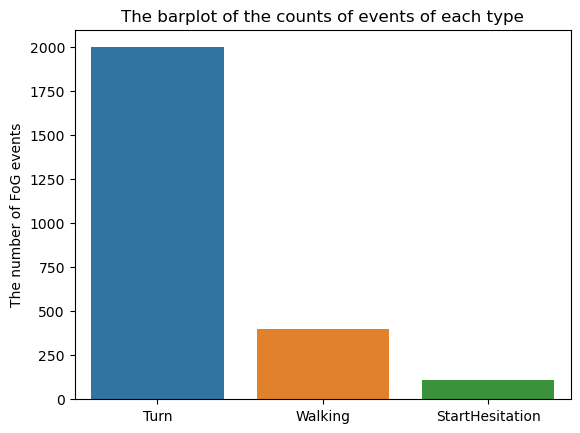

In [143]:
sns.barplot(x=events_data['Type'].value_counts().index,
            y=events_data['Type'].value_counts())
plt.title('The barplot of the counts of events of each type')
plt.ylabel('The number of FoG events')
plt.show()

Most events are `Turn` events. Based on the videos posted, this makes sense because a lot of the FoG events occured while turning.

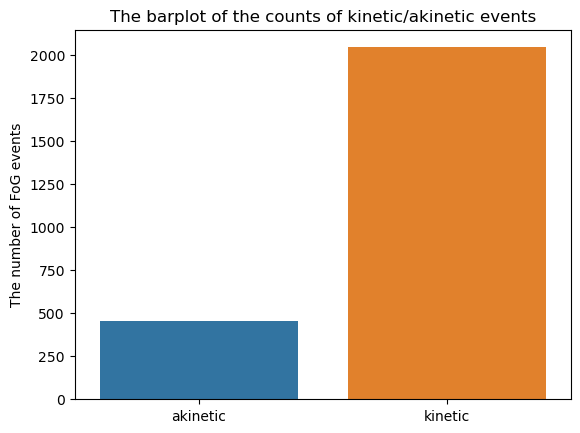

In [144]:
fig, ax = plt.subplots()
sns.barplot(x=events_data['Kinetic'].value_counts().index,
            y=events_data['Kinetic'].value_counts())
plt.title('The barplot of the counts of kinetic/akinetic events')
plt.ylabel('The number of FoG events')
ax.set_xticklabels(['akinetic', 'kinetic'])
plt.show()

Most events are `kinetic` events.

In [145]:
events_data['Duration'] = events_data['Completion'] - events_data['Init']

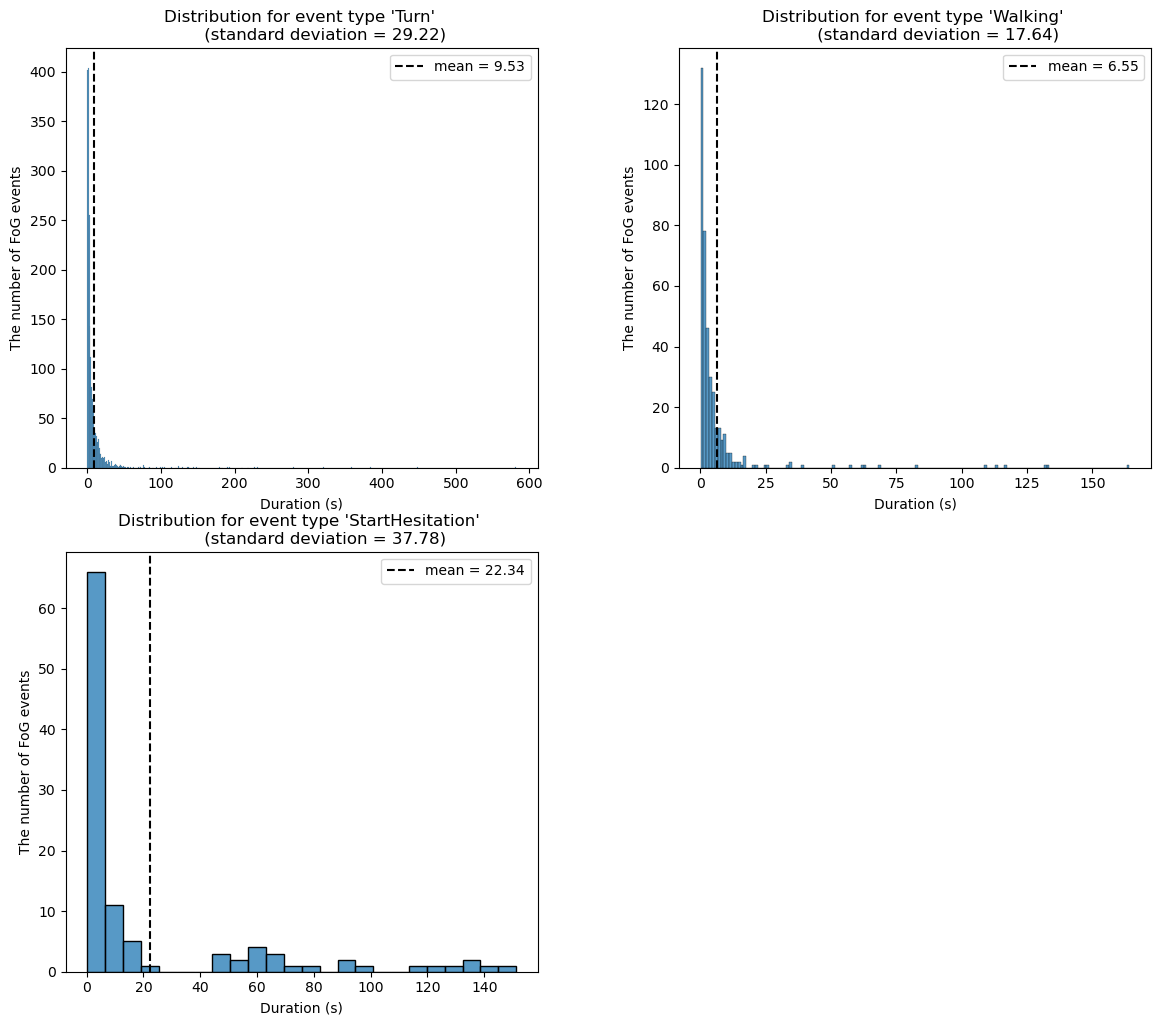

In [146]:
plt.figure(figsize=(14, 12))
for i, column in enumerate(events_data['Type'].dropna().unique(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(events_data[events_data['Type'] == column].Duration)
    plt.xlabel(f'Duration (s)')
    plt.ylabel('The number of FoG events')
    plt.axvline(
        events_data[events_data['Type'] == column].Duration.mean(), linestyle='dashed',
        label= f'mean = {events_data[events_data.Type == column].Duration.mean():.2f}',
        color='black')
    plt.legend(loc='best')
    plt.title(f"Distribution for event type '{column}' \n \
        (standard deviation = {events_data[events_data['Type'] == column].Duration.std():.2f})")
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

The values for each Type is skewed right. Lets keep this in mind as we progress.

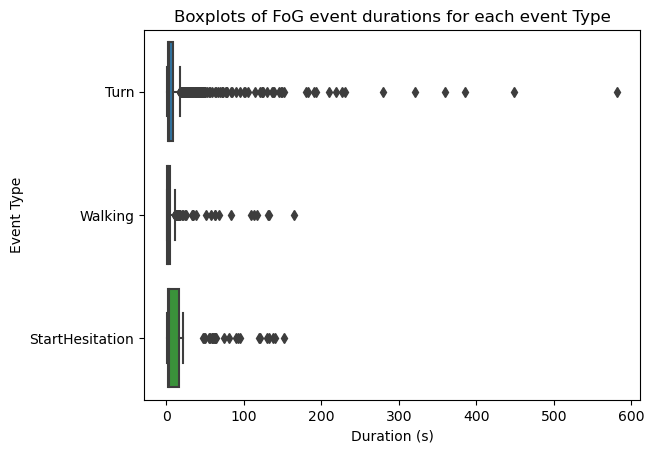

In [147]:
data_1 = events_data[events_data['Type'] == 'Turn'].Duration
data_2 = events_data[events_data['Type'] == 'Walking'].Duration
data_3 = events_data[events_data['Type'] == 'StartHesitation'].Duration

fig, ax = plt.subplots()
sns.boxplot([data_1, data_2, data_3], orient='h')
plt.xlabel(f"Duration (s)")
plt.ylabel('Event Type')
ax.set_yticklabels(['Turn', 'Walking', 'StartHesitation'])
plt.title(f"Boxplots of FoG event durations for each event Type")
plt.show()

This is just another way to look at the data, as we can see there is a wide range of values and it might be more worthwhile to find the 95th percentile than the 5th percentile given the skewedness of the data.

In [148]:
for t in events_data['Type'].dropna().unique():
    print('Type: ', t)
    print(events_data[events_data.Type == t].Duration.agg(
        ['min', 'max', 'median', 'mean', 'std']))
    print(f'The value of 95th percentile: \
        {events_data[events_data.Type == t].Duration.quantile(0.95):.2f}')
    print('-'* 10 + '\n')

Type:  Turn
min         0.124000
max       581.980000
median      2.920000
mean        9.532709
std        29.224874
Name: Duration, dtype: float64
The value of 95th percentile:         29.27
----------

Type:  Walking
min         0.119000
max       164.200000
median      2.140000
mean        6.554683
std        17.639786
Name: Duration, dtype: float64
The value of 95th percentile:         17.41
----------

Type:  StartHesitation
min         0.240000
max       151.240000
median      3.320000
mean       22.343252
std        37.784590
Name: Duration, dtype: float64
The value of 95th percentile:         120.58
----------



## Subjects
We will now take a look at the Subject data. As stated from the competition.<br>
>subjects.csv Metadata for each Subject in the study, including their `Age` and `Sex` as well as:
>
>* `Visit` Only available for subjects in the daily and defog datasets.
>* `YearsSinceDx` Years since Parkinson's diagnosis.
>* `UPDRSIIIOn`/`UPDRSIIIOff` Unified Parkinson's Disease Rating Scale score during on/off medication respectively.
>* `NFOGQ` Self-report FoG questionnaire score. See: https://pubmed.ncbi.nlm.nih.gov/19660949/

In [149]:
subjects_data.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,00f674,2.0,63,M,27.0,43.0,49.0,24
1,00f674,1.0,63,M,27.0,31.0,30.0,26
2,02bc69,NaN,69,M,4.0,21.0,NaN,22
3,040587,2.0,75,M,26.0,52.0,69.0,21
4,040587,1.0,75,M,26.0,47.0,75.0,24


In [150]:
subjects_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Subject       173 non-null    object 
 1   Visit         111 non-null    float64
 2   Age           173 non-null    int64  
 3   Sex           173 non-null    object 
 4   YearsSinceDx  173 non-null    float64
 5   UPDRSIII_On   172 non-null    float64
 6   UPDRSIII_Off  132 non-null    float64
 7   NFOGQ         173 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 10.9+ KB


As stated above, we see null values in visits, which is the case for subjects that only recorded at home, and therefore had no visits. `UPDRSIII_On` and `UPDRSIII_Off` my have missing values because patients might have only been on medication or off medication.

In [151]:
subjects_data['Subject'].value_counts().sort_values(ascending=False)

00f674    2
fcb9f5    2
c56629    2
c83ff6    2
c92925    2
         ..
f62eec    1
f686f0    1
f80507    1
fa8764    1
72716b    1
Name: Subject, Length: 136, dtype: int64

According to the subject data metafile, subjects can have repeats. This makes sense seeing how they can have multiple visits to the clinic. 

In [152]:
ProfileReport(subjects_data, title='Subjects Dataset Report',
              progress_bar=False,
              interactions=None,
              explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

Most notable is the correlation between `UPDRSIII_On` and `UPDRSIII_Off`. This makes sense given underlying disease progression, which would be a co-factor to both columns here.

## Task
Next lets look at the task metadata. As stated in the competition:

>**tasks.csv** : Task metadata for series in the ***defog*** dataset. (Not relevant for the series in the ***tdcsfog*** or ***daily*** datasets.)
>
>* `Id` The data series where the task was measured.
>* `Begin` Time (s) the task began.
>* `End` Time (s) the task ended.
>* `Task` One of seven tasks types in the DeFOG protocol, described on <a href="https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/overview/additional-data-documentation" style="text-decoration:none">this page</a>.

In [153]:
tasks_data.head()

,Id,Begin,End,Task
0,02ab235146,10.00,190.48,Rest1
1,02ab235146,211.24,271.56,Rest2
2,02ab235146,505.88,522.40,4MW
3,02ab235146,577.96,594.64,4MW-C
4,02ab235146,701.32,715.28,MB1


In [154]:
tasks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817 entries, 0 to 2816
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      2817 non-null   object 
 1   Begin   2817 non-null   float64
 2   End     2817 non-null   float64
 3   Task    2817 non-null   object 
dtypes: float64(2), object(2)
memory usage: 88.2+ KB


In [155]:
tasks_data['Task'].value_counts()

TUG-ST        278
TUG-DT        267
4MW           137
Turning-DT    137
Turning-ST    137
Hotspot1      130
Hotspot2      130
MB3-R         124
MB3-L         120
TUG-C         119
MB12           70
MB4            69
MB13           68
MB1            67
MB11           67
MB5            66
MB2b           66
MB10           66
MB9            65
MB8            65
4MW-C          65
MB7            65
MB6-L          62
MB6-R          61
Turning-C      61
Hotspot1-C     59
Hotspot2-C     59
Rest1          45
Rest2          44
MB2a           42
MB6             6
Name: Task, dtype: int64

In [156]:
tasks_data['Task'].value_counts().count()

31

Interestingly there are 31 values for Tasks, even though the data for the metafile states their are 7 types of tasks for the defog dataset. If you read the document, it seems that some of the 7 tasks can be split up into multiple parts. We will determine later how important this is. In addition this is data only availble for defog data set, and I intend to combine data sets to increase our sample size for models in the future.

## Daily metadata

Each series in the ***daily*** dataset is identified by the `Subject` id. This file also contains the time of day the recording began.

In [157]:
daily_metadata.head()

,Id,Subject,Visit,Beginning of recording [00:00-23:59]
0,00c4c9313d,fba3a3,1,10:19
1,07a96f89ec,7da72f,1,07:30
2,0d1bc672a8,056372,2,08:30
3,0e333c9833,b4bd22,1,11:30
4,164adaed7b,9f72eb,1,13:00


In [158]:
daily_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Id                                    65 non-null     object
 1   Subject                               65 non-null     object
 2   Visit                                 65 non-null     int64 
 3   Beginning of recording [00:00-23:59]  65 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.2+ KB


In [159]:
daily_metadata['Id'].value_counts()

00c4c9313d    1
7ab610bb34    1
88f67f91db    1
8959244e1c    1
8ca674a988    1
             ..
57741bad42    1
5bf570bb7b    1
5e13d48878    1
6e0303484e    1
f3fa3bf72d    1
Name: Id, Length: 65, dtype: int64

In [160]:
daily_metadata['Subject'].value_counts()

fba3a3    1
5d9cae    1
702778    1
6aaeab    1
107712    1
         ..
8caf40    1
8d43d9    1
60bc2a    1
6d2031    1
d89567    1
Name: Subject, Length: 65, dtype: int64

Not much usually information here.

## defog_metadata

**defog_metadata.csv** : Identifies each series in the ***defog*** dataset by a unique `Subject`, `Visit`, `Medication` condition.

In [161]:
defog_metadata.head()

,Id,Subject,Visit,Medication
0,02ab235146,e1f62e,2,on
1,02ea782681,ae2d35,2,on
2,06414383cf,8c1f5e,2,off
3,092b4c1819,2874c5,1,off
4,0a900ed8a2,0e3d49,2,on


In [162]:
defog_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          137 non-null    object
 1   Subject     137 non-null    object
 2   Visit       137 non-null    int64 
 3   Medication  137 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.4+ KB


The most important data here is the medication data.

## tdcsfog_metadata

**tdcsfog_metadata.csv** : Identifies each series in the ***tdcsfog*** dataset by a unique `Subject, Visit, Test, Medication` condition.

* `Visit` Lab visits consist of a baseline assessment, two post-treatment assessments for different treatment stages, and one follow-up assessment.
* `Test` Which of three test types was performed, with 3 the most challenging.
* `Medication` Subjects may have been either off or on anti-parkinsonian medication during the recording.

In [163]:
tdcsfog_metadata.head()

,Id,Subject,Visit,Test,Medication
0,003f117e14,4dc2f8,3,2,on
1,009ee11563,f62eec,4,2,on
2,011322847a,231c3b,2,2,on
3,01d0fe7266,231c3b,2,1,off
4,024418ba39,fa8764,19,3,on


In [164]:
tdcsfog_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          833 non-null    object
 1   Subject     833 non-null    object
 2   Visit       833 non-null    int64 
 3   Test        833 non-null    int64 
 4   Medication  833 non-null    object
dtypes: int64(2), object(3)
memory usage: 32.7+ KB


Just like the defog metadata, the most important data here is the medication data.

## Combine defog and tdcsfog meta datasets

Since both datasets have similarities in action of what the subjects performed, it would be worthwhile to study both groups together. Keep in mind, the readings of the actual accelerometer data is recorded at different frequencies, but we can account for this later. 

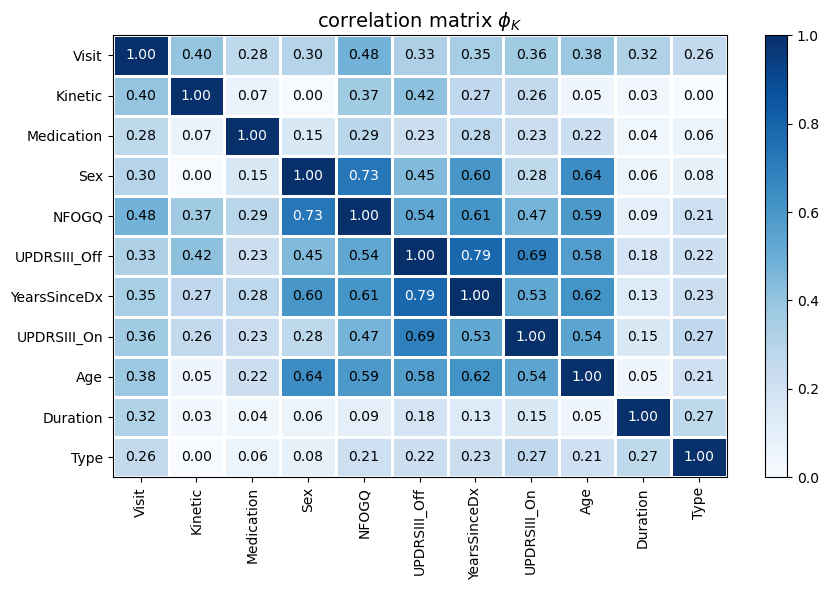

In [165]:
tdcsfog_metadata['dataset'] = 'tdcsfog'
defog_metadata['dataset'] = 'defog'

full_metadata = pd.concat([tdcsfog_metadata, defog_metadata])

all_metadata_df = events_data[['Id', 'Type', 'Kinetic', 'Duration']] \
                            .merge(full_metadata, on='Id') \
                            .merge(subjects_data.drop('Visit', axis=1), on='Subject')
all_metadata_df.Sex = np.where(all_metadata_df.Sex == 'F', 0, 1)
all_metadata_df.Medication = np.where(all_metadata_df.Medication == 'off', 0, 1)

columns_phik = ['Type', 'Duration', 'Age', 'UPDRSIII_On', 'YearsSinceDx',
                'UPDRSIII_Off', 'NFOGQ', 'Sex', 'Medication', 'Kinetic', 'Visit']
phik_overview = all_metadata_df[columns_phik].phik_matrix( \
                                    interval_cols=['Duration', 'Age',
                                                'UPDRSIII_On', 'YearsSinceDx',
                                                'UPDRSIII_Off','NFOGQ'])

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,
                        y_labels=phik_overview.index, vmin=0, vmax=1,
                        color_map='Blues', title=r'correlation matrix $\phi_K$',
                        figsize=(9, 6))
plt.show()

`NFOGQ` is a questionaire about disease progression, so it makes sense it would be correlated with `YearsSinceDX` and `Age`. `Sex` might have to do with differences in responses for men and women, there are numerous studies that show men are less likely to report symptoms of their diseases, not matter what diseases are present for them. This is especially true for things like depression. 

`YearsSinceDx`, as one would expect, is correlated with disease progression as well. This all makes intuitive sense.

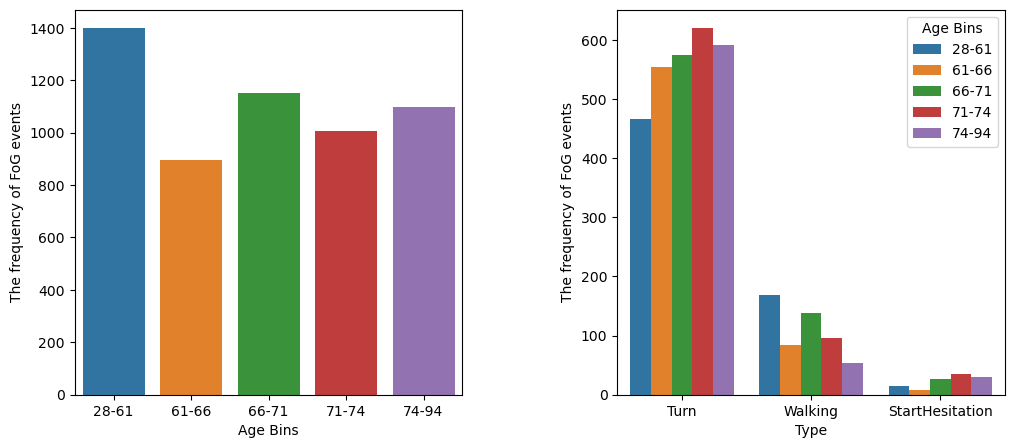

In [166]:
# bin the Age column based on quantiles

plt.figure(figsize=(12, 5))
all_metadata_df['age_bin'] = pd.qcut(all_metadata_df['Age'], q=5)
plt.subplot(1, 2, 1)
sns.countplot(data = all_metadata_df,
        x='age_bin')
locs, labels = plt.xticks()
new_labels = ['28-61','61-66','66-71','71-74','74-94']
plt.xticks(locs,new_labels)
plt.xlabel('Age Bins')
plt.ylabel('The frequency of FoG events')
plt.subplot(1, 2, 2)
sns.countplot(data = all_metadata_df,
        x='Type',
        hue = 'age_bin')
L=plt.legend()
[L.get_texts()[i].set_text(new_labels[i]) for i in range(len(new_labels))]
L.set_title('Age Bins')
plt.ylabel('The frequency of FoG events')
plt.subplots_adjust(wspace=0.4)
plt.show()

Hard to infer too much from this data, given we do not know if the samples collected were collected in a that would not introduce some form of collection bias.

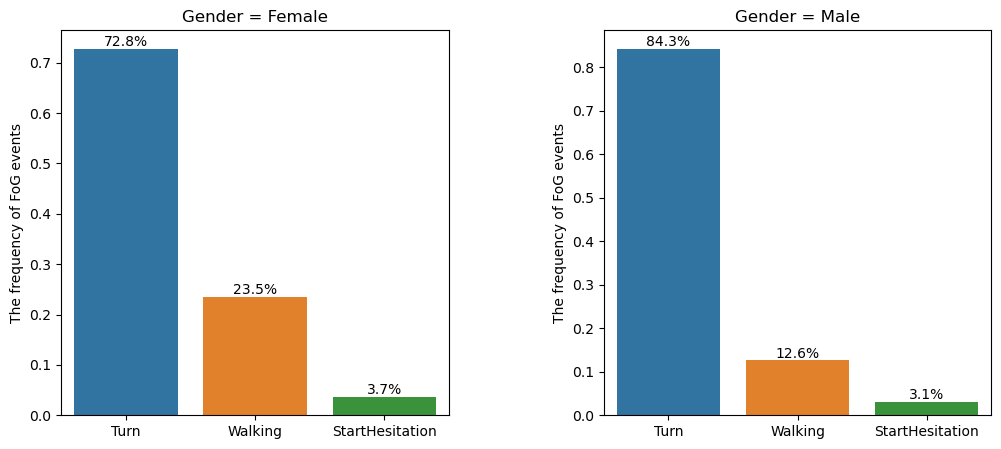

In [167]:
plt.figure(figsize=(12, 5))
gender_dict = {0: 'Female', 1: 'Male'}
for i, gender in enumerate(all_metadata_df['Sex'].unique(), 1):
    plt.subplot(1, 2, i)
    sns.barplot(
        x=all_metadata_df[all_metadata_df['Sex'] == gender].Type
                                .value_counts(normalize=True).index,
        y=all_metadata_df[all_metadata_df['Sex'] == gender].Type
                                .value_counts(normalize=True))
    plt.ylabel('The frequency of FoG events')
    plt.title(f"Gender = {gender_dict[gender]}")
    
    for index, value in enumerate(
            all_metadata_df[all_metadata_df['Sex'] == gender].Type
                                    .value_counts(normalize=True)):
        plt.annotate(f"{value * 100:.1f}%", xy=(index, value),
                                    ha='center', va='bottom')
plt.subplots_adjust(wspace=0.4)
plt.show()

It is interesting that the percentage of walking events is almost double for females compared to males, comming from turning events.

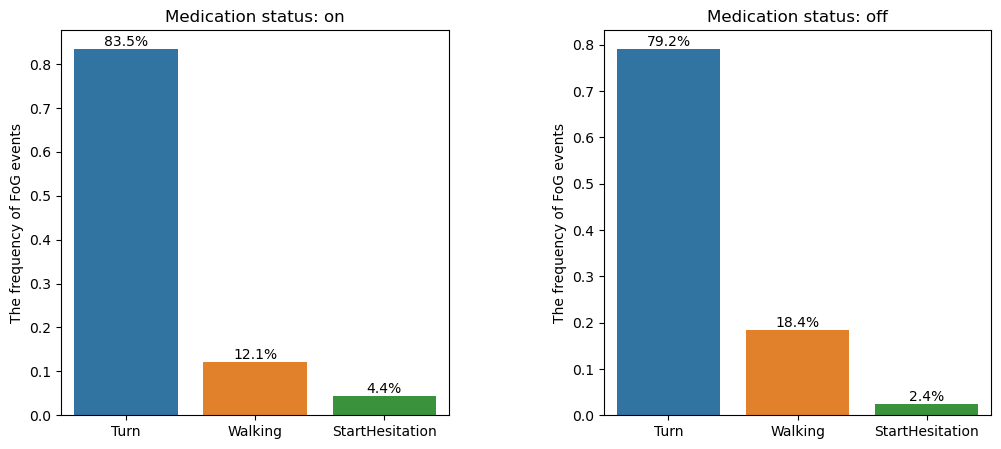

In [168]:
plt.figure(figsize=(12, 5))
med_dict = {0: 'Medication status: off', 1: 'Medication status: on'}
for i, med_status in enumerate(all_metadata_df['Medication'].unique(), 1):
    plt.subplot(1, 2, i)
    sns.barplot(
        x=all_metadata_df[all_metadata_df['Medication'] == med_status].Type
                                        .value_counts(normalize=True).index,
        y=all_metadata_df[all_metadata_df['Medication'] == med_status].Type
                                        .value_counts(normalize=True))
    plt.ylabel('The frequency of FoG events')
    plt.title(f'{med_dict[med_status]}')
    
    # Add frequency values on top of the bars
    for index, value in enumerate(
            all_metadata_df[all_metadata_df['Medication'] == med_status].Type
                                            .value_counts(normalize=True)):
        plt.annotate(f'{value * 100:.1f}%', xy=(index, value),
                                    ha='center', va='bottom')
plt.subplots_adjust(wspace=0.4)
plt.show()

Similar to the above inferences, its hard to infer too much from on and off medication datasets, might be more interesting to look at an individual patient on and off medication, but there are not too many of those in this dataset.

## Viewing samples of each event

### Tdcsfog
Let as look at the actual accelerometer data for each of these events. Let us look at the controlled events first with the **Tdcsfog** data files.

In [169]:
tdcsfog_files = [f'{data_dir}train/tdcsfog/{id}.csv' for id in \
                                         tdcsfog_metadata.Id.to_list()]

tdcsfog_data = pd.concat([pd.read_csv(file) for file in tdcsfog_files])

ProfileReport(tdcsfog_data, title='Tdcsfog Dataset Report',
              progress_bar=False,
              interactions=None,
              explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

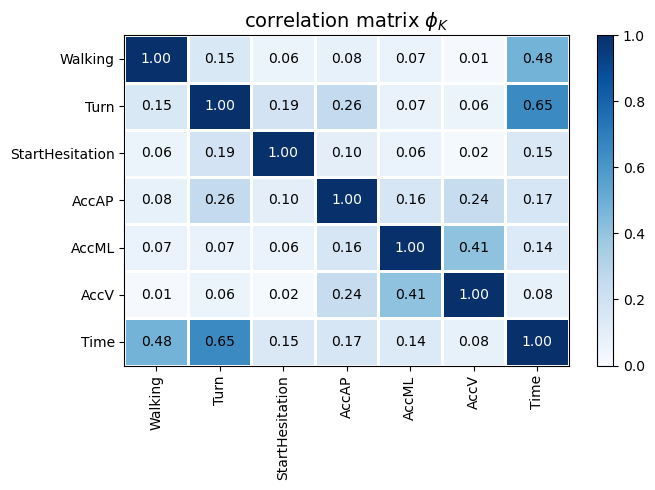

In [170]:
phik_overview = tdcsfog_data.phik_matrix(
                            interval_cols=['AccV', 'AccML', 'AccAP','Time'])

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,
                        y_labels=phik_overview.index, vmin=0, vmax=1, 
                        color_map='Blues', title=r'correlation matrix $\phi_K$',
                        figsize=(7, 5))
plt.show()

There is a slight correlation between the `Time` column and `Walking` and `Turn`. This may be due to the fact that subjects are illiciting a FoG response and there me a certain time point that correlates with when these events occur during a FoG event.

Let us take a look at some of the files to get a respresentitive of what each `Type` of event looks like.

In [171]:
tdcsfog_files_turn = [f'{data_dir}train/tdcsfog/{id}.csv' for id in \
                              tdcsfog_metadata.Id.to_list()[16:17]]

tdcsfog_data_turn = pd.concat([pd.read_csv(file) for file in tdcsfog_files_turn])

# Read one file of the tdcsfog train data with event of Walking type
tdcsfog_files_walk = [f'{data_dir}train/tdcsfog/{id}.csv' for id in \
                              tdcsfog_metadata.Id.to_list()[19:20]]

tdcsfog_data_walk = pd.concat([pd.read_csv(file) for file in tdcsfog_files_walk])

# Read one file of the tdcsfog train data with event of StartHesitation type
tdcsfog_files_hes = [f'{data_dir}train/tdcsfog/{id}.csv' for id in \
                             tdcsfog_metadata.Id.to_list()[77:78]]

tdcsfog_data_hes = pd.concat([pd.read_csv(file) for file in tdcsfog_files_hes])

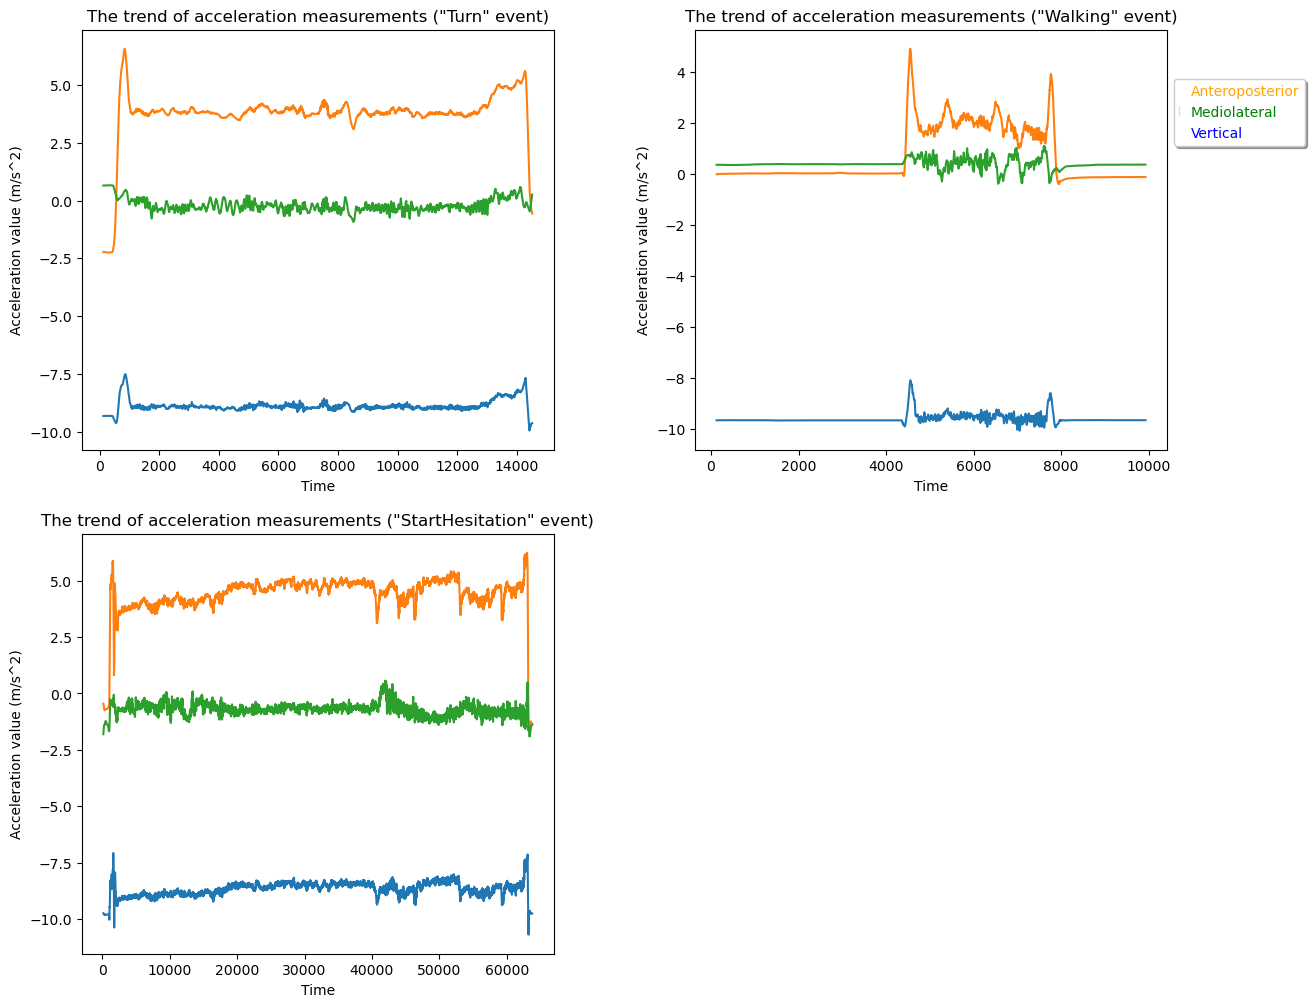

In [172]:
plt.figure(figsize=(14, 12))

types_dict = {1: 'Turn', 2: 'Walking', 3: 'StartHesitation'}

for i, data in enumerate(
            [tdcsfog_data_turn, tdcsfog_data_walk, tdcsfog_data_hes], 1):
    plt.subplot(2, 2, i)
    window_size = 128
    accv_rolling_mean = data["AccV"].rolling(window_size).mean()
    accap_rolling_mean = data["AccAP"].rolling(window_size).mean()
    accml_rolling_mean = data["AccML"].rolling(window_size).mean()

    sns.lineplot(x=data.Time, y=accv_rolling_mean)
    sns.lineplot(x=data.Time, y=accap_rolling_mean)
    sns.lineplot(x=data.Time, y=accml_rolling_mean)
    plt.title(f'The trend of acceleration measurements ("{types_dict[i]}" event)')
    plt.xlabel('Time')
    plt.ylabel('Acceleration value (m/s^2)')

plt.legend(['Anteroposterior', 'Mediolateral', 'Vertical'], loc='upper left',
               bbox_to_anchor=(2.3, 2.1), handlelength=0,
               shadow=True, labelcolor=['orange', 'green', 'blue'])
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

The ends are pretty indicitive of some form of event. It is hard to draw any conclusion from just looking at one example.

### Defog

Let us take a look at the **defog** set. Keep in mind the notype folder is for files in the defog set that are not actually labelled by a reader, so we have to filter these out of the metadata.

In [173]:
notype_idx = [0, 4, 13, 15, 17, 19, 20, 22, 25, 27, 30, 31, 32, 34, 36, 40, 42,
              53, 54, 55, 58, 60, 62, 66, 67, 73, 74, 76, 79, 83, 84, 88, 89, 94,
              96, 97, 98, 101, 102, 105, 113, 114, 115, 121, 124, 126]

defog_metadata_only = defog_metadata[~defog_metadata.index.isin(notype_idx)].copy()
notype_metadata = defog_metadata[defog_metadata.index.isin(notype_idx)].copy()

In [174]:
defog_files = [f'{data_dir}train/defog/{id}.csv' for id in \
                               defog_metadata_only.Id.to_list()[:1]]

defog_data = pd.concat([pd.read_csv(file) for file in defog_files])

defog_data_valid = defog_data.loc[ \
                        (defog_data.Valid == True) & (defog_data.Task == True)]

ProfileReport(defog_data, title='Defog Dataset Report',
              progress_bar=False,
              interactions=None,
              explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

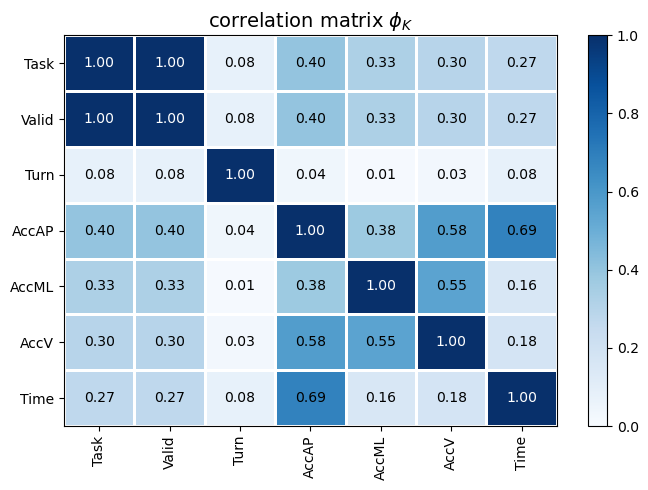

In [175]:
phik_overview = defog_data.phik_matrix(
                            interval_cols=['AccV', 'AccML', 'AccAP', 'Time'])

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,
                        y_labels=phik_overview.index, vmin=0, vmax=1, 
                        color_map='Blues', title=r'correlation matrix $\phi_K$',
                        figsize=(7, 5))
plt.show()

We can ignore the `Valid` and the `Task` columns, as that is a prerequisit to be included in the defog set.

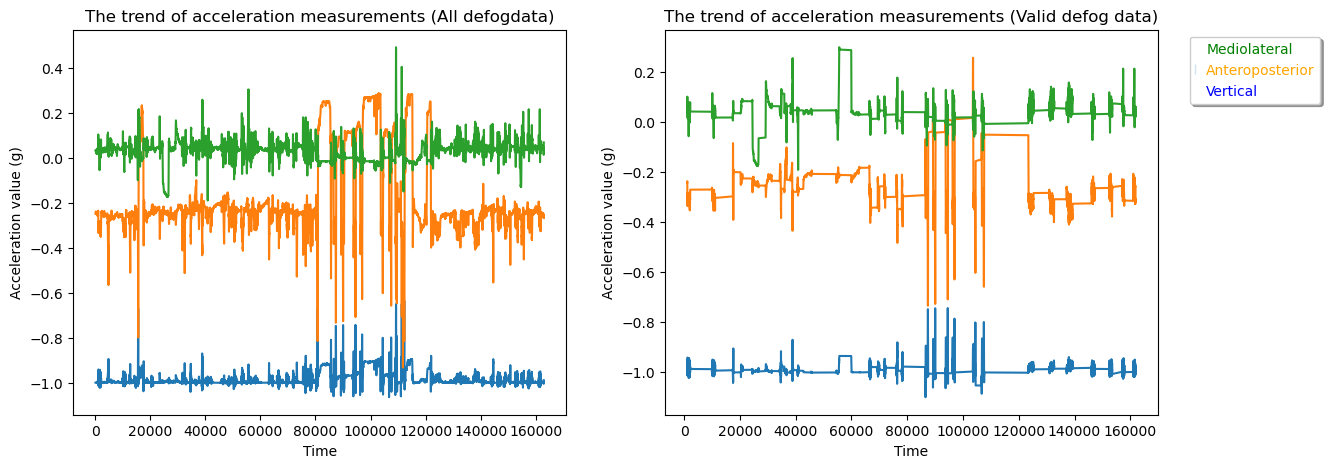

In [176]:
plt.figure(figsize=(14, 5))

defogdata_dict = {1: 'All defogdata', 2: 'Valid defog data'}

for i, data in enumerate([defog_data, defog_data_valid], 1):
    plt.subplot(1, 2, i)
    window_size = 100
    accv_rolling_mean = data['AccV'].rolling(window_size).mean()
    accap_rolling_mean = data['AccAP'].rolling(window_size).mean()
    accml_rolling_mean = data['AccML'].rolling(window_size).mean()

    sns.lineplot(x= data['Time'], y=accv_rolling_mean)
    sns.lineplot(x= data['Time'], y=accap_rolling_mean)
    sns.lineplot(x= data['Time'], y=accml_rolling_mean)
    plt.title(f'The trend of acceleration measurements ({defogdata_dict[i]})')
    plt.xlabel('Time')
    plt.ylabel('Acceleration value (g)')

plt.legend(['Mediolateral', 'Anteroposterior', 'Vertical'], loc= 'upper left',
               bbox_to_anchor= (1.05, 1), shadow= True, handlelength= 0,
               labelcolor= ['green', 'orange', 'blue'])
plt.show()

The valid defog data tend to smoother than the combined dataset.